In [3]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
image_dir = 'C:\\Users\\Karthick Selvam\\Downloads\\PYTORCH\\contents\\Classification_dataset_v3\\images\\train'
for label, class_dir in enumerate(os.listdir(image_dir)):
  print(label, class_dir)

0 Cat
1 Dog
2 person


In [5]:
class ImageDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.image_paths = []
    self.labels = []
    self.class_name = {}
    self.transform = transform

    for label, class_dir in enumerate(os.listdir(image_dir)):
      self.class_name[label] = class_dir
      class_path = os.path.join(image_dir, class_dir)
      for img_name in os.listdir(class_path):
        self.image_paths.append(os.path.join(class_path, img_name))
        self.labels.append(label)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image = Image.open(img_path).convert("RGB")
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

In [7]:
train_image_dir = 'C:\\Users\\Karthick Selvam\\Downloads\\PYTORCH\\contents\\Classification_dataset_v3\\images\\train'
test_image_dir = 'C:\\Users\\Karthick Selvam\\Downloads\\PYTORCH\\contents\\Classification_dataset_v3\\images\\test'

train_image_dataset = ImageDataset(image_dir=train_image_dir, transform=transform)
test_image_dataset = ImageDataset(image_dir=test_image_dir, transform=transform)

In [8]:
train_image_loader = DataLoader(dataset=train_image_dataset, batch_size=32, shuffle=True)
test_image_loader = DataLoader(dataset=test_image_dataset, batch_size=32, shuffle=True)

In [9]:
for images,labels in train_image_loader:
  print(images.shape, labels.shape)
  break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
print(train_image_dataset.class_name)
print(test_image_dataset.class_name)

{0: 'Cat', 1: 'Dog', 2: 'person'}
{0: 'Cat', 1: 'Dog', 2: 'person'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


torch.Size([32, 3, 128, 128]) torch.Size([32])
(3, 128, 128)
person
(128, 128, 3)
2


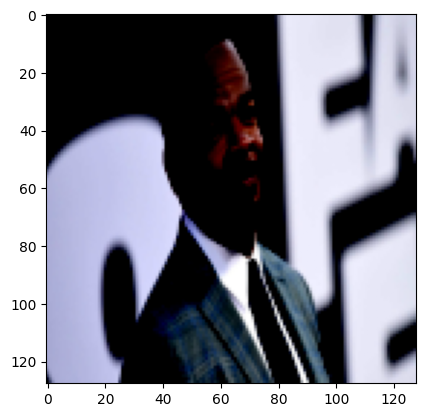

In [12]:
for images, labels in train_image_loader:
  print(images.shape, labels.shape)
  img = images[0].numpy()
  print(img.shape)
  label = labels[0].item()
  print(train_image_dataset.class_name[label])
  img = np.transpose(img, (1,2,0))
  print(img.shape)
  print(label)
  plt.imshow(img)
  break

# Custom CNN Architecture

In [13]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class CustomCnnModel(nn.Module):
  def __init__(self,input_dim, num_classes):
    super(CustomCnnModel, self).__init__()
    self.input_dim = input_dim
    self.num_classes = num_classes

    self.conv_layers = nn.Sequential(
        # C1
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        # 128x128x3 --> 3x3x3x32 --> wxhx32
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # C2
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # C3
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # C4
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self._to_linear = None
    self._get_conv_output(self.input_dim)

    self.fc_layers = nn.Sequential(
        nn.Linear(self._to_linear, 512),
        nn.ReLU(),
        # nn.Dropout(0.2)
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, self.num_classes),
    )

    # 256 x 12 x 12

  def _get_conv_output(self, input_dim=128):
    with torch.no_grad():
      dummy_input = torch.zeros(1,3, input_dim, input_dim)
      output = self.conv_layers(dummy_input)
      self._to_linear = output.view(1, -1).size(1)

  def forward(self,x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [15]:
# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCnnModel(input_dim=128, num_classes=3).to(device)

In [16]:
print(model)

CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [18]:
# 100 epoch

# 1000
# 10 batch size
# 100

# 1 epoch --> 100 iteration
# 2 epoch --> 100 iteration

In [19]:
len(train_image_loader)

95

In [ ]:
# Training loop
epochs = 40
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_image_loader:
    images,labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # [x, 3, 128, 128]

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  print(f"Epoch {epoch+1}/{epochs}, Loss : {running_loss/len(train_image_loader)}")


Epoch 1/40, Loss : 1.012879561123095
Epoch 2/40, Loss : 0.5969778663233707
Epoch 3/40, Loss : 0.506260904356053
Epoch 4/40, Loss : 0.49382952247795303
Epoch 5/40, Loss : 0.4504880448705272
Epoch 6/40, Loss : 0.38598577317438626


In [ ]:
torch.save(model.state_dict(), "cnn_model.pth")

In [ ]:
for images, labels in test_image_loader:
  print(labels.shape)
  break

torch.Size([32])


In [ ]:
# Evaluate model

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_image_loader:
    images,labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test accuracy is :{100* correct / total:.2f}%")


Test accuracy is :74.50%


In [ ]:
import cv2

In [ ]:
class ImageClassifier:
  def __init__(self, model_path, class_names):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model = CustomCnnModel(input_dim=128, num_classes=3).to(self.device)
    self.model.load_state_dict(torch.load(model_path, map_location=self.device))
    self.model.eval()
    self.class_names = class_names
    self.transform = transforms.Compose([
      transforms.Resize((128,128)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
    )

  def predict(self, image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = self.transform(image).unsqueeze(0).to(self.device)
    with torch.no_grad():
      output = self.model(input_tensor)
      _, predicted = torch.max(output, 1)
    label = self.class_names[predicted.item()]

    img = cv2.imread(image_path)
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.imwrite("output_image.jpg",img)
    return label



In [ ]:
classfier = ImageClassifier("/content/saved/cnn_model.pth", train_image_dataset.class_name )
label = classfier.predict("/content/Classification_dataset_v3/images/test/Dog/dog_1000.jpg")
print(f"Predicted class is : {label}")

Predicted class is : Dog


<ipython-input-66-0994c84929d5>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))
